# Part 1/N Tracking larval zebrafish

This is a short intro

Today we will

    1) Load the video
    2) Learn what thresholding is
    3) Use image moments to track the fish

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as io
%matplotlib inline

In [2]:
import imageio as io

In [3]:
ims = io.mimread("Zebrafish.mp4", memtest=False)

Multidimensional array TxHxWxC

In [4]:
ims = np.asarray(ims)
ims.shape

(2500, 488, 648, 3)

**Way 1 to get rid of extra channels --> Take 1**

In [16]:
way1 = ims[..., 0]

**Way 2 to get rid --> Mean**

However: since the data will be transferred from uint8 to float(64bits), the memory is going to bloat!

In [ ]:
#way2 = ims.mean(3)

In [ ]:
#print(ims.dtype)
#print(way1.dtype)
#print(way2.dtype)

**Good way is:**

Because actually the layers are weighted (Check the function documentation!)

In [7]:
from skimage.color import rgb2gray
#rgb2gray(ims) #takes too long, maybe my memory is not enough!

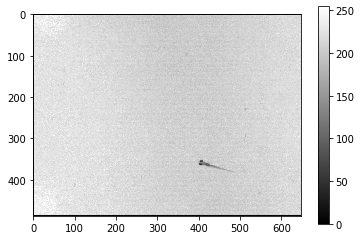

In [6]:
plt.imshow(ims[0], cmap='gray')
plt.colorbar()

In [17]:
im = way1[0]

In [9]:
from ipywidgets import interact

In [18]:
@interact
def threshold(t:(0, 255)):
    plt.imshow((im > t).astype(np.uint8))
    plt.colorbar()

interactive(children=(IntSlider(value=127, description='t', max=255), Output()), _dom_classes=('widget-interac…

In [34]:
t = 85
ims = way1
ims = ims[:, 4:-4, 4:-4]

In [35]:
@interact
def thresholdOverMovie(frame:(0, ims.shape[0]-1), t:(0, 255)):
    plt.imshow((ims[frame] < t).astype(np.uint8))
    plt.colorbar()

interactive(children=(IntSlider(value=1249, description='frame', max=2499), IntSlider(value=127, description='…

Image moments Mpq = sum(sum(x^p*y^q)) = Area , can get the centroid!

In [25]:
from skimage.measure import moments

In [36]:
im = ims[0]
t = 82 # threshold

In [37]:
M = moments(im < 82) # left to right > moment 00 01 02 03 and then the next row is 10 11 12 13 etc..

In [38]:
M[0, 0]

44.0

In [41]:
y, x = M[1, 0]/M[0, 0], M[0, 1]/M[0, 0]

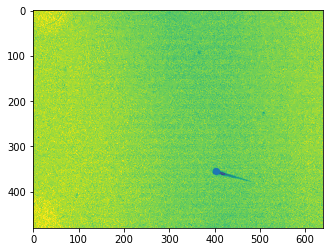

In [42]:
plt.imshow(im)
plt.scatter(x, y)

In [46]:
from tqdm.notebook import tqdm
# Progress bar

In [53]:
threshold = 82
positions = np.zeros((ims.shape[0], 2))

for frame in tqdm(range(ims.shape[0])):
    # calculate the positions
    # 1) get image
    im = ims[frame]
    # 2) threshold
    thresholded_im = im < threshold
    # 3) compute position
    M = moments(thresholded_im)
    y, x = M[1, 0]/M[0, 0], M[0,1]/M[0, 0]
    # 4) append image position
    positions[frame] = y, x

In [49]:
from collections import namedtuple

In [54]:
pos = namedtuple('position', ['x', 'y'])

In [55]:
positions[frame]

array([440.85714286, 501.55102041])

In [59]:
@interact
def showFrameAndTrace(up_to_frame:(0, ims.shape[0]-1)):
    plt.subplot(121)
    plt.imshow(ims[up_to_frame])
    
    plt.subplot(122)
    plt.plot(*positions[:up_to_frame][:, ::-1].T)
    plt.axis('equal')
    plt.xlim([0, 640])
    plt.ylim([480, 0])

interactive(children=(IntSlider(value=1249, description='up_to_frame', max=2499), Output()), _dom_classes=('wi…

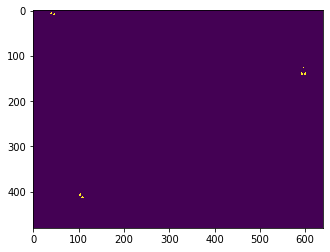

In [60]:
plt.imshow(ims[1905] < threshold)

In [61]:
from skimage.feature import blob_dog, blob_log, blob_doh

In [67]:
individual_fish = blob_dog(ims[1905] < threshold, threshold=.2)

/Users/onurserce/opt/anaconda3/envs/ffmpeg/lib/python3.7/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/Users/onurserce/opt/anaconda3/envs/ffmpeg/lib/python3.7/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/Users/onurserce/opt/anaconda3/envs/ffmpeg/lib/python3.7/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/Users/onurserce/opt/anaconda3/envs/ffmpeg/lib/python3.7/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


In [68]:
individual_fish

array([[410.     , 106.     ,   4.096  ],
       [140.     , 597.     ,   6.5536 ],
       [  0.     ,  42.     ,  10.48576]])

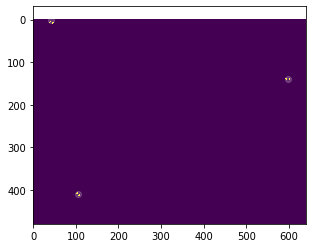

In [72]:
plt.imshow(ims[1905] < threshold)
for fish in individual_fish:
    plt.scatter(fish[1], fish[0], alpha=.2, c='w')